In [1]:
import DeltaQ.Workbench.Numeric
import Text.Printf
import Data.Maybe

Simple 'Cache' performance optimisation example
=======

_Time is but an illusion - Lunch Time doubly so. Choose your scaling factor as needed_

You have an existing service ('off the shelf') that takes between 4s and 6s and has an (inherent) failure ratio of 0.1% (99.9% success).

Simplified expression: ∅ (999⇋1) ⊥ ⊕ δ⎣4.0⎤ ⊕ ⊓[0,2.0]

CoTS reliabilty: 0.999

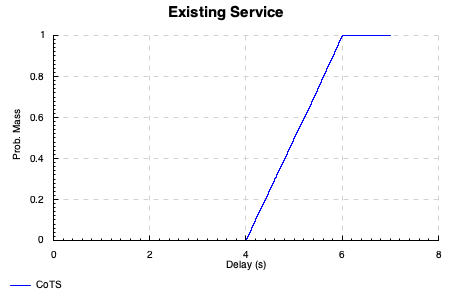

In [2]:
x1 = (⇋) (999/1000) perfection bottom ⊕ uniform 4 6 :: DeltaQ
printf "Simplified expression: %s" (show x1)
printf "CoTS reliabilty: %f" $ 1 - lossprob x1
plotDQs "Existing Service" [("CoTS", x1)]

The desire is to create an optimised service that delivers 50% of its outcomes within 3s, 95% of them within 5s and 99.95% within 6s.

Minimum acceptable reliablity: 0.9995

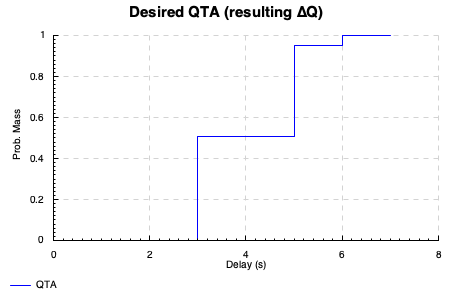

In [3]:
qta1 = fromQTA [(0.5, 3), (0.95, 5), (0.9995, 6)] :: DeltaQ
printf "Minimum acceptable reliablity: %f" $ 1 - lossprob qta1
plotDQs "Desired QTA (resulting ∆Q)" [("QTA", qta1)]

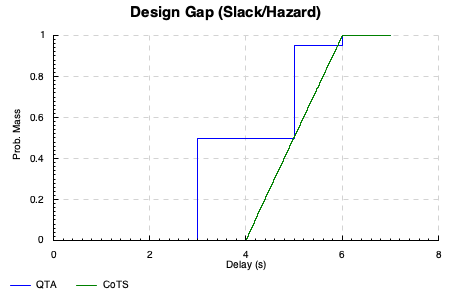

In [4]:
plotDQs "Design Gap (Slack/Hazard)" [("QTA", qta1), ("CoTS", x1)]

As can be seen, this is (almost) entirely "in hazard". Can caching help? How much performance is needed in the cache? What sort of cache hit rates are needed?  

Cache lookups take time (say 0.1s), we will also assume that the CoTS system is relatively precious/expensive so we will make concurrent lookups against it.

A ∆Q model of the cache - takes some time, has some success probabilty then either responds from cache or falls back on the CoTS service. We are assuming that the cache has a reliablity of 99.999 (five nines)

In [ ]:
cacheModel cacheHitRate hitDq missDq = (⇋) 0.99999 (δ 0.1 ⊕ (⇋) cacheHitRate hitDq missDq) bottom

System reliablilty: 0.9999800001

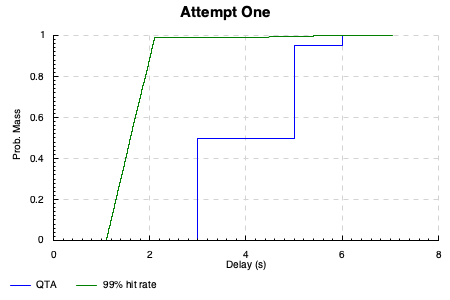

In [ ]:
try1 = cacheModel (99/100) (uniform 1 2) x1 :: DeltaQ
printf "System reliablilty: %f" $ 1 - lossprob try1
plotDQs "Attempt One" [("QTA", qta1), ("99% hit rate", try1)]

So it works, but (for the sake of argument) that sort of cache is 'expensive'. There is plenty of 'slack' in the proposed solution - could we live with a lower hit rate? Budget would suggest a 50% hit rate was more affordable.

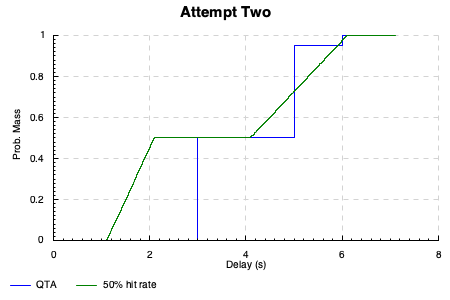

In [ ]:
try2 = cacheModel (50/100) (uniform 1 2) x1 :: DeltaQ
plotDQs "Attempt Two" [("QTA", qta1), ("50% hit rate", try2)]

This is looking promising - but we're not meeting the QTA (between about 5s and 6s); could we introduce a two level cache? The second level cache is slower, it takes between 1.5s and 4s to yeild a result, however it is cheaper, let's size it for 50% hit rate.

We'll assume that we sequentially check each cache before reaching out to the underlying service.

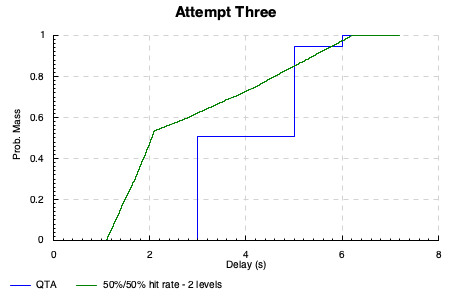

In [ ]:
try3 = cacheModel (50/100) (uniform 1 2) (cacheModel (50/100) (uniform 1.5 4) x1)
plotDQs "Attempt Three" [("QTA", qta1), ("50%/50% hit rate - 2 levels", try3)]

This is nearly there. However the cost differential between the L1 and L2 cache is large, for every 1% of reduction in L1 we can have 2.5%-3/0% increase in L2 for the same price. Perhaps we can do a bit better?

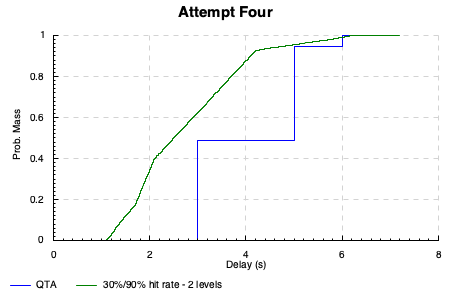

In [ ]:
try4 =  cacheModel (30/100) (uniform 1 2) (cacheModel (90/100) (uniform 1.5 4) x1)
plotDQs "Attempt Four" [("QTA", qta1), ("30%/90% hit rate - 2 levels", try4)]

Of course, the budget is everything and anything we can do shrink that L1 cache frees up some monetary slack.... 

System Reliability: 0.9999020

Min/max response Time: 1.100/6.200, mean/stddev: 2.860/0.647

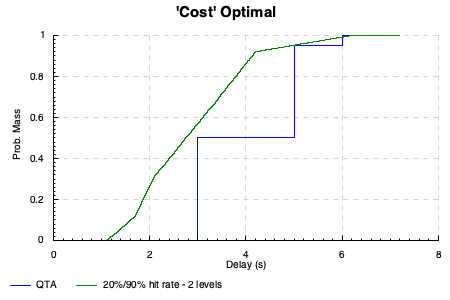

In [ ]:
try5 =  cacheModel (20/100) (uniform 1 2) (cacheModel (90/100) (uniform 1.5 4) x1) :: DeltaQ
printf "System Reliability: %0.7f" $ 1 - lossprob try5
try5' =  fromJust $ mmmv try5
printf "Min/max response Time: %0.3f/%0.3f, mean/stddev: %0.3f/%0.3f" (mmmvMin try5') (mmmvMax try5') (mmmvMean try5') (sqrt $ mmmvVar try5')
plotDQs "'Cost' Optimal" [("QTA", qta1), ("20%/90% hit rate - 2 levels", try5)]

We have investigated (to some level of fidelity) a design space that takes a CoTS, adds a front-end cache to create a performance (and 'cost' optimal) solution.

Not only were we able to optimise with respect to performance and cost, we were also able to ensure that the resulting system reliablity exceeded the target (*Note:* the cache component reliability has to be at least four nines - but that is just a parameter in the model).

We have done this exploration graphically, but that was just for pedagogical purposes - all the underlying properties for automation are present.
